# FIFA

> Process data from FIFA.


In [ ]:
#| default_exp fifa

In [ ]:
#| hide
import requests
import json
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
%config InlineBackend.figure_format = 'retina'

from nbdev.showdoc import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

In [ ]:
#| export
def fetch_fifa_rankings(gender):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    if gender == 'men':
        url = 'https://inside.fifa.com/api/rankings/by-country?gender=1&countryCode=IND&locale=en'
    else:
        url = 'https://inside.fifa.com/api/rankings/by-country?gender=2&countryCode=IND&locale=en'

    response = requests.get(url, headers = headers)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print('Error fetching data: ', response.status_code)
        return None

In [ ]:
#| export
def write_fifa_rankings(response, filepath):
    with open(filepath, 'w') as f:
        json.dump(response, f, indent=4)

In [ ]:
#| export
def parse_fifa_rankings(response):
    df = pd.json_normalize(response['rankings'])

    # Clean column names: convert to lowercase and replace spaces or special characters with underscores
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '_', regex=True)

    df['pubdate'] = pd.to_datetime(df['pubdate'])
    df.sort_values('pubdate', ascending=True, inplace=True)

    return df

### World Ranking


In [ ]:
response = fetch_fifa_rankings(gender = 'men')
write_fifa_rankings(response, '../data/fifa_rankings_men.json')

men = parse_fifa_rankings(response)
print(men.shape)
men.tail(3)

(338, 25)


,idteam,teamname,gender,idconfederation,rankingmovement,rankingmovementstring,confederationname,idcountry,rank,idschedule,prevrank,eoyrank,totalpoints,decimaltotalpoints,prevpoints,statusranked,decimalprevpoints,eoypoints,decimaleoypoints,matches,pubdate,prepubdate,eoypubdate,nextpubdate,isupdateable
2,43815,"[{'Locale': 'en-GB', 'Description': 'India'}]",1,25998,1.0,1,AFC,IND,125,id14541,126.0,102.0,1134,1133.78,1134,1,1133.52,1201,1200.8,45.0,2024-10-24 07:50:00+00:00,2024-09-19T00:00:00Z,2023-12-21T00:00:00Z,None,None
1,43815,"[{'Locale': 'en-GB', 'Description': 'India'}]",1,25998,-2.0,-2,AFC,IND,127,id14576,125.0,102.0,1134,1133.62,1134,1,1133.78,1201,1200.8,46.0,2024-11-28 12:50:00+00:00,2024-10-24T00:00:00Z,2023-12-21T00:00:00Z,None,None
0,43815,"[{'Locale': 'en-GB', 'Description': 'India'}]",1,25998,1.0,1,AFC,IND,126,id14597,127.0,102.0,1134,1133.62,1134,1,1133.62,1201,1200.8,46.0,2024-12-19 08:50:00+00:00,2024-11-28T00:00:00Z,2023-12-21T00:00:00Z,None,None


In [ ]:
response = fetch_fifa_rankings(gender = 'women')
write_fifa_rankings(response, '../data/fifa_rankings_women.json')

women = parse_fifa_rankings(response)
print(women.shape)
women.tail(3)

(90, 25)


,idteam,teamname,gender,idconfederation,rankingmovement,rankingmovementstring,confederationname,idcountry,rank,idschedule,prevrank,eoyrank,totalpoints,decimaltotalpoints,prevpoints,statusranked,decimalprevpoints,eoypoints,decimaleoypoints,matches,pubdate,prepubdate,eoypubdate,nextpubdate,isupdateable
2,106918,"[{'Locale': 'en-GB', 'Description': 'India'}]",2,11158,-1.0,-1,AFC,IND,68.0,ranking_20240816,67,65,1389,1389.02,1389,1,1389.02,1393,1392.59,129.0,2024-08-16 07:50:00+00:00,2024-06-14T00:00:00Z,2023-12-15T00:00:00Z,None,None
1,1885024,"[{'Locale': 'en-GB', 'Description': 'India'}]",2,11158,-1.0,-1,AFC,IND,69.0,ranking_20241213,68,65,1375,1374.66,1389,1,1389.02,1393,1392.59,132.0,2024-12-13 08:50:00+00:00,2024-08-16T00:00:00Z,2023-12-15T00:00:00Z,None,None
0,1885024,"[{'Locale': 'en-GB', 'Description': 'India'}]",2,11158,0.0,0,AFC,IND,69.0,ranking_20250306,69,65,1378,1378.44,1375,1,1374.66,1393,1392.59,135.0,2025-03-06 08:50:00+00:00,2024-12-13T00:00:00Z,2023-12-15T00:00:00Z,None,None


In [ ]:
# Create a function to generate future FIFA rankings data
def generate_future_rankings(last_data, target_year=2046, target_rank=1):

    last_date = pd.to_datetime(last_data['pubdate'].iloc[-1])
    last_rank = last_data['rank'].iloc[-1]
    
    # Calculate how many years to generate
    years_to_generate = target_year - last_date.year
    
    # Calculate the average decrease per year to reach rank 1
    avg_decrease_per_year = (last_rank - target_rank) / years_to_generate
    
    # Generate dates and ranks
    future_dates = []
    future_ranks = []
    current_date = last_date
    current_rank = last_rank
    
    for year in range(1, years_to_generate + 1):
        # Generate 4-6 FIFA rankings per year (typical for FIFA)
        num_updates = random.randint(4, 6)
        
        for _ in range(num_updates):
            # Add 45-75 days between updates (with some variance)
            days_to_add = random.randint(45, 75)
            current_date += timedelta(days=days_to_add)
            
            # Calculate expected rank decrease for this update
            expected_decrease = avg_decrease_per_year / num_updates
            
            # Add some randomness to the rank change (-1 to +0.5 around expected)
            random_factor = random.uniform(-1, 0.5)
            rank_change = expected_decrease + random_factor
            
            # Ensure rank generally decreases but can occasionally increase slightly
            current_rank = max(1, current_rank - rank_change)
            
            future_dates.append(current_date)
            future_ranks.append(round(current_rank, 1))
    
    # Ensure the last rank is exactly 1
    if future_ranks and future_dates:
        target_date = datetime(target_year, 12, 22)  # End of target year
        future_dates.append(target_date)
        future_ranks.append(1.0)
    
    # Generate a dataframe
    future_df = pd.DataFrame({
        'pubdate': future_dates,
        'rank': future_ranks
    })
    
    return future_df

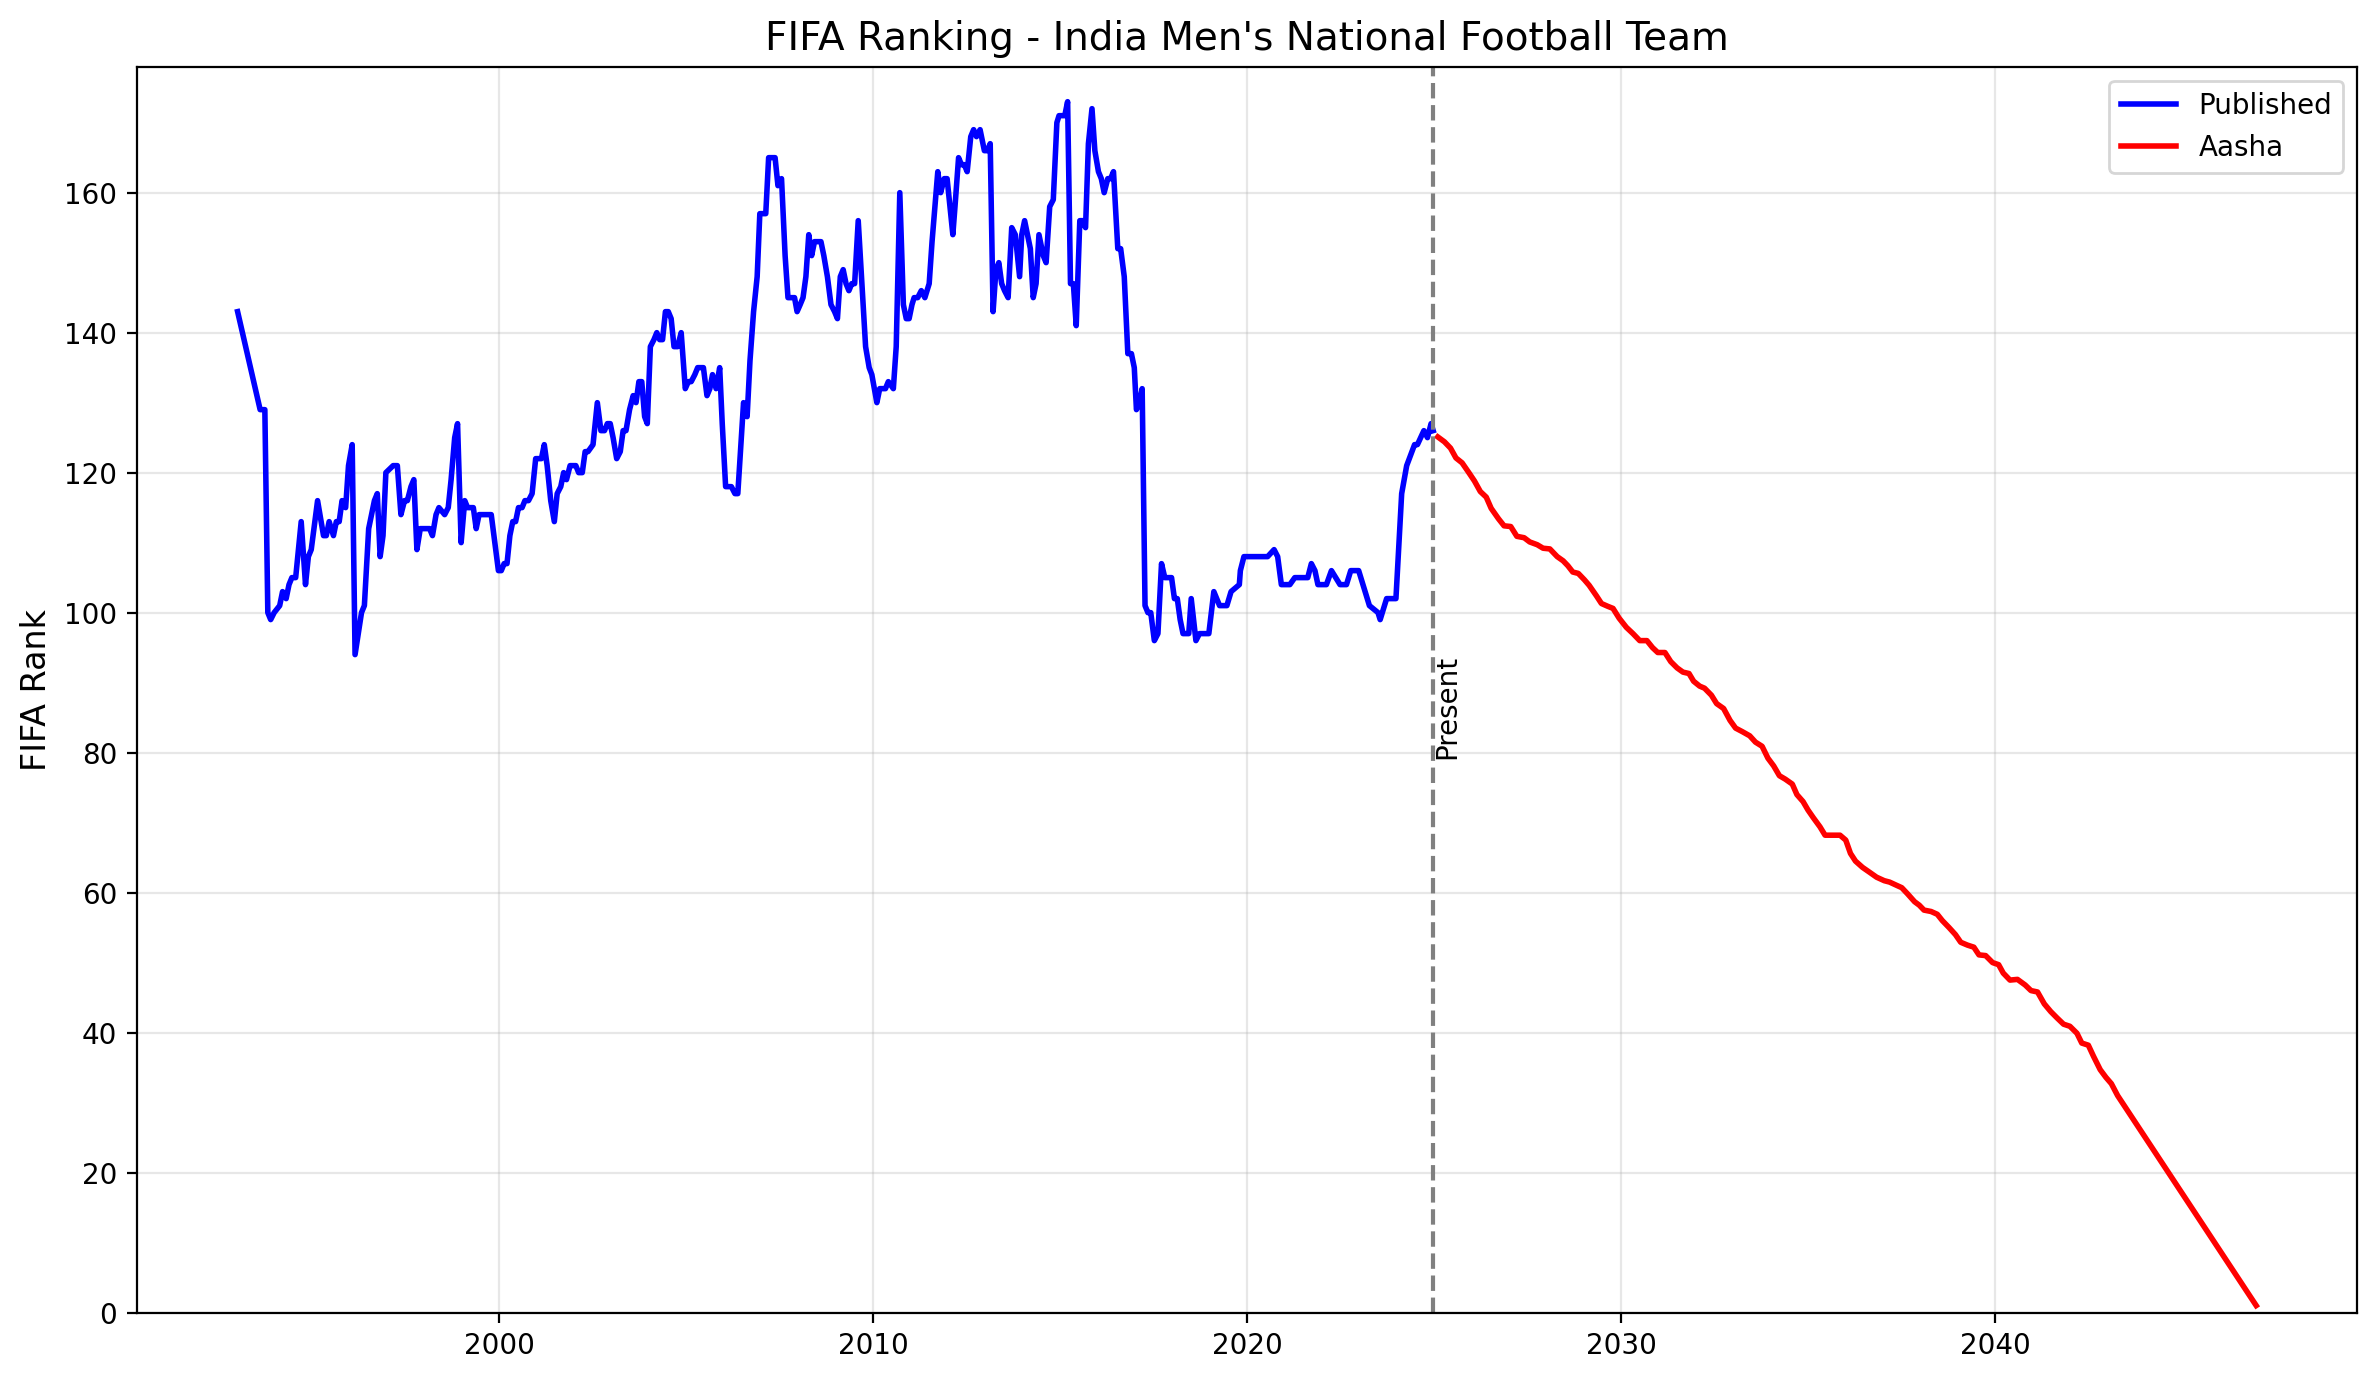

In [ ]:
# Generate future data with target year 2046
future_men = generate_future_rankings(men, target_year=2046, target_rank=1)
all_data = pd.concat([men[['pubdate', 'rank']], future_men], ignore_index=True)

# Plot the data with inverted y-axis starting from 0.
plt.figure(figsize=(12, 7))
plt.plot(pd.to_datetime(men['pubdate']), men['rank'], '-', color='blue', linewidth=2, label='Published')
plt.plot(future_men['pubdate'], future_men['rank'], '-', color='red', linewidth=2, label='Aasha')

# Add a vertical line to separate historical and projected data
last_historical_date = pd.to_datetime(men['pubdate'].iloc[-1])
plt.axvline(x=last_historical_date, color='gray', linestyle='--')
plt.text(last_historical_date, max(men['rank']) * 0.5, 'Present', rotation=90, verticalalignment='center')

plt.title('FIFA Ranking - India Men\'s National Football Team', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('FIFA Rank', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Invert y-axis so rank 1 is at the top
plt.gca().invert_yaxis()

max_rank = max(max(men['rank']), max(future_men['rank']))
plt.ylim(0, max_rank + 5)

plt.tight_layout()
plt.savefig('images/asha_men.png', dpi=300, bbox_inches='tight')
plt.show()

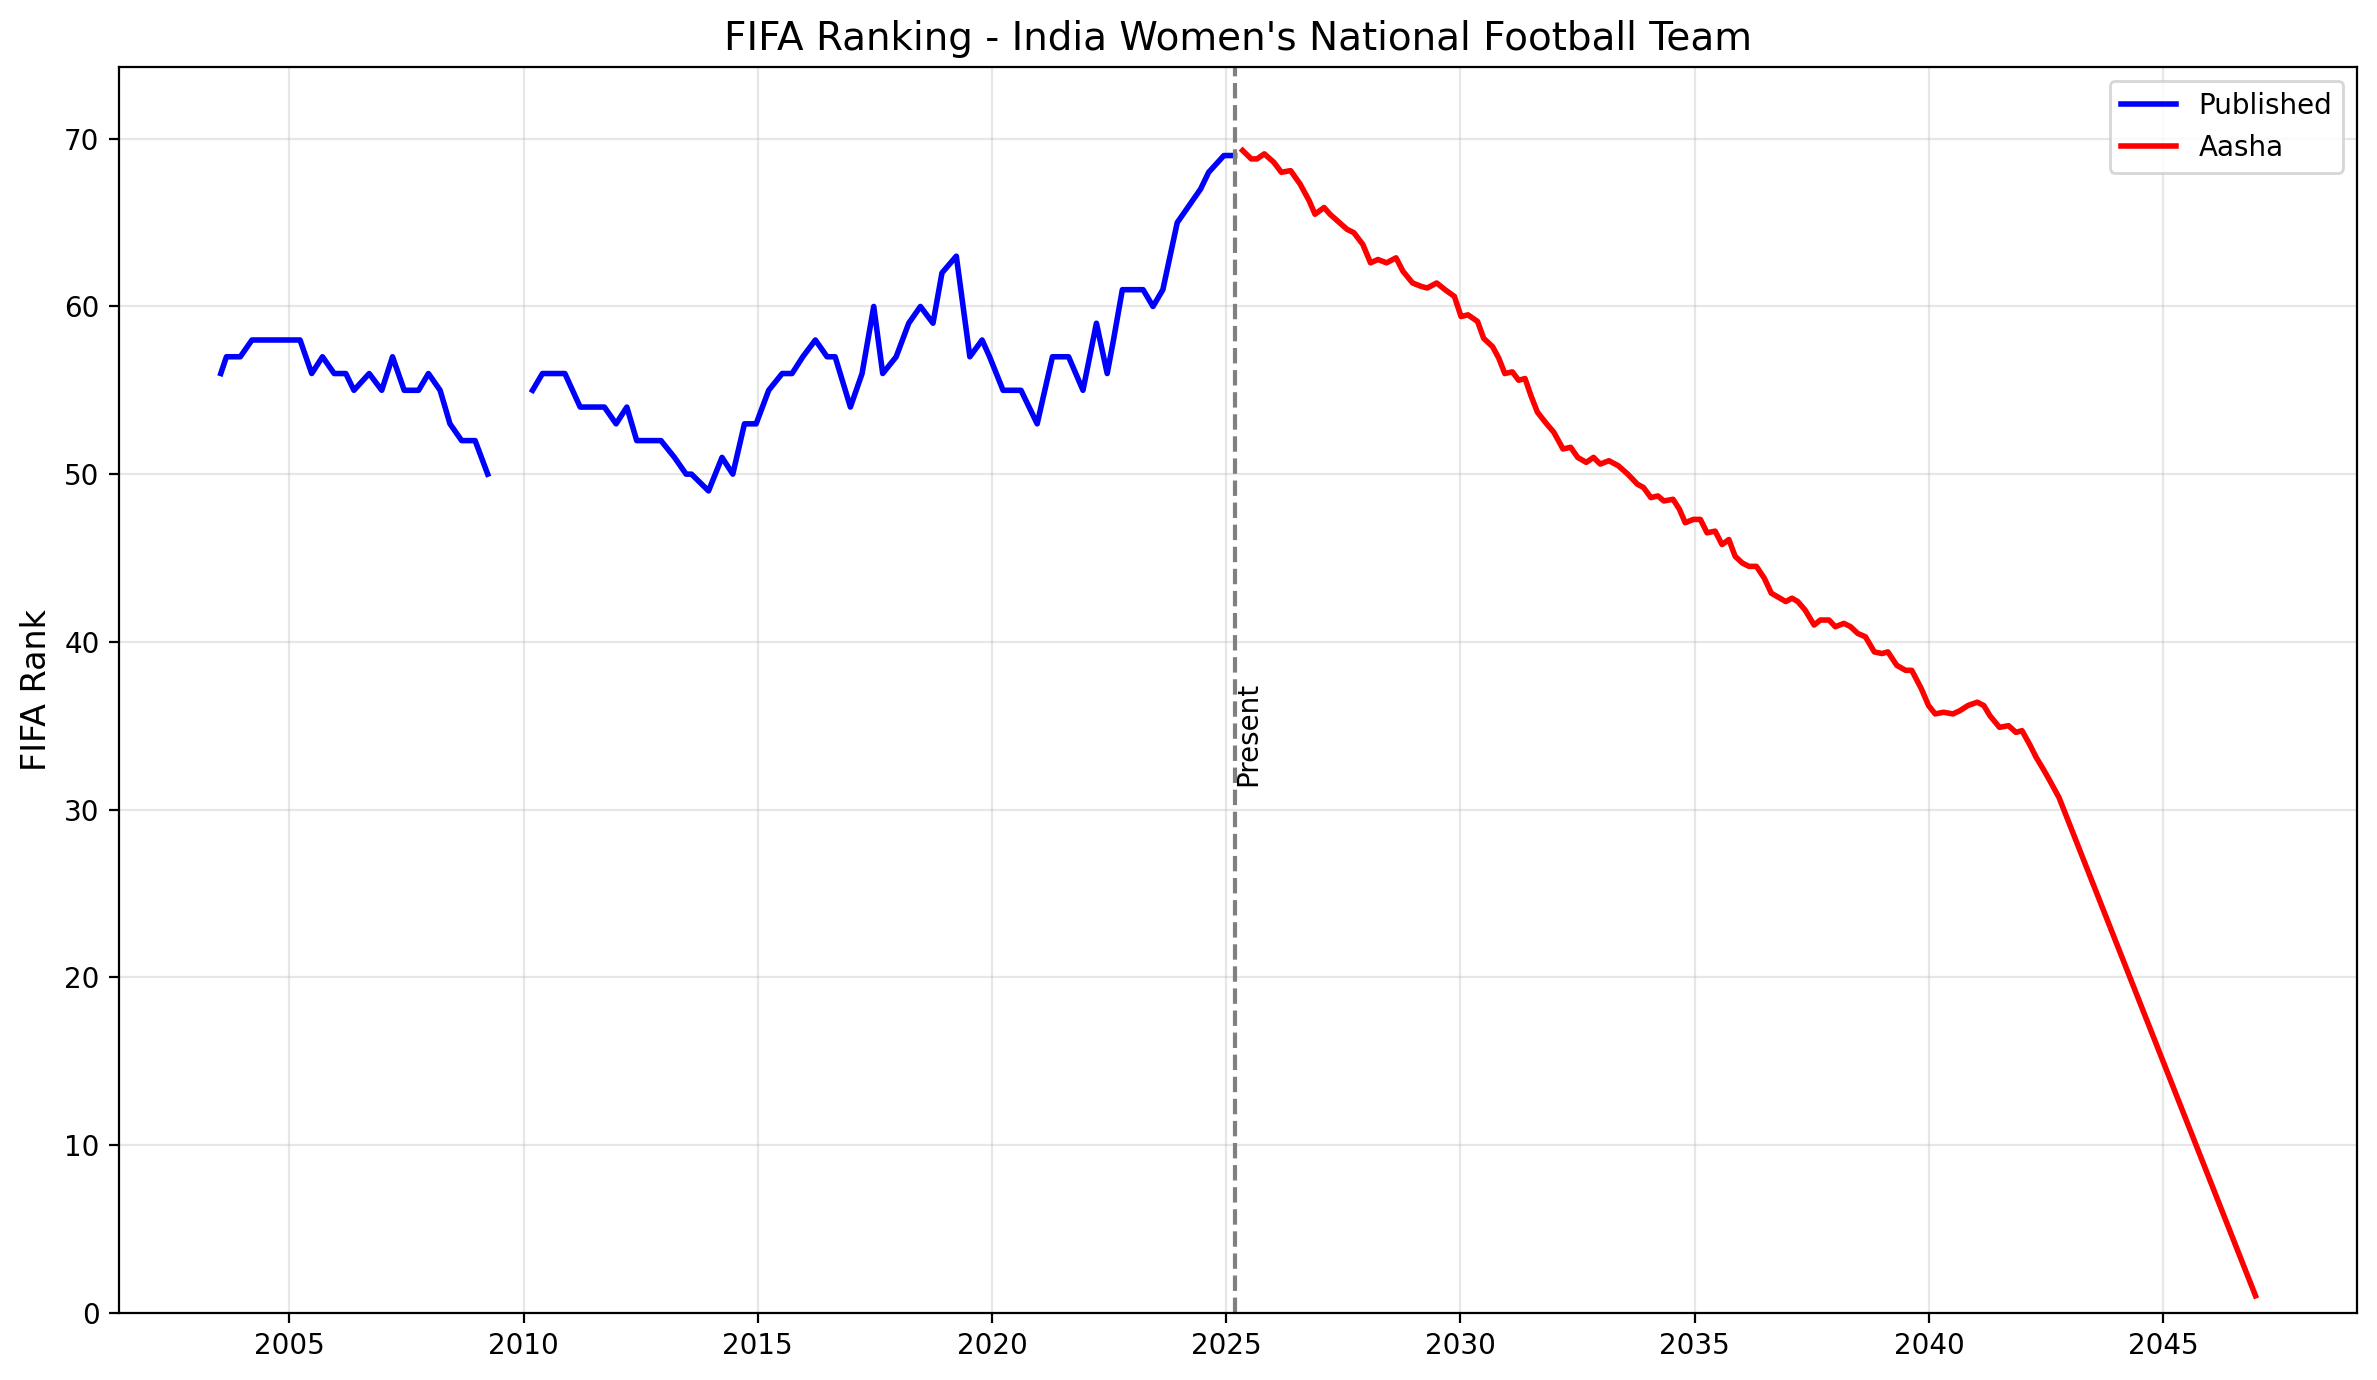

In [ ]:
# Generate future data with target year 2046
future_women = generate_future_rankings(women, target_year=2046, target_rank=1)
all_data = pd.concat([women[['pubdate', 'rank']], future_women], ignore_index=True)

# Plot the data with inverted y-axis starting from 0.
plt.figure(figsize=(12, 7))
plt.plot(pd.to_datetime(women['pubdate']), women['rank'], '-', color='blue', linewidth=2, label='Published')
plt.plot(future_women['pubdate'], future_women['rank'], '-', color='red', linewidth=2, label='Aasha')

# Add a vertical line to separate historical and projected data
last_historical_date = pd.to_datetime(women['pubdate'].iloc[-1])
plt.axvline(x=last_historical_date, color='gray', linestyle='--')
plt.text(last_historical_date, max(women['rank']) * 0.5, 'Present', rotation=90, verticalalignment='center')

plt.title('FIFA Ranking - India Women\'s National Football Team', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('FIFA Rank', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Invert y-axis so rank 1 is at the top
plt.gca().invert_yaxis()

max_rank = max(max(women['rank']), max(future_women['rank']))
plt.ylim(0, max_rank + 5)

plt.tight_layout()
plt.savefig('images/asha_women.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()